# Read the helpr class file 'All_helper_classes.ipynb' and instantiate the three helper classes

In [ ]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers = default_model_helpers_for_project()

In [2]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Get project paths from helper classes
access using paths.THE_PATH

In [3]:
gc.collect()
paths = project_paths()
#Get the latest version of the aggregated already audited data (output from the audit tool) directly from GIT


# Set github user and password for pushing files directly to git

In [111]:
GIT_USER = '****'
GIT_PSWD = '****'

# Read Training_Data, Gathered_Data and Audited_Data

In [4]:
USE_GIT_HUB = True  #Use github directly to read the training data and gathered data


# Read aggregated training data from TRAINING_DATA_DIR_FILE_LOCAL or TRAINING_DATA_DIR_FILE_GIT 
# and stores the content in a dataframe variable named 'training_df'. 
# Files in GATHERED_DATA_FOLDER are combined with the content of 'training_df' 
# to create the vocabulary of the Tokenizer, as by design, ```"tokenizer.tokenize()"``` 
# will remove any words not seen on the ```"tokenizer.fit()"``` stage.
                                                      

# Read the already static training data file "paths.TRAINING_DATA_DIR_FILE" with column_to_clean = 'text' and return 
# a pandas Data Frame of training data
training_df = model_helpers.get_training_data(
                            USE_GIT_HUB,
                            paths.TRAINING_DATA_DIR_FILE_GIT,
                            paths.TRAINING_DATA_DIR_FILE_LOCAL, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)


# Note the helper file contains two methods, one Method to aggregate the audited data and to return a pandas DB containing the aggregated content.
# * aggregate_audited_data_from_git(...)
# THe other Method is to get the latest aggregate audited data and to return a pandas DB containing the aggregated content.
# * get_aggregated_gathered_data(....)
# Here we are using the one to get the latest file.
# Read the gathered_data files "paths.TRAINING_DATA_DIR_FILE" with column_to_clean = 'text' and return 
# a pandas Data Frame
gathered_conventions_files, gathered_conventions_df = model_helpers.get_aggregated_gathered_data (
                            USE_GIT_HUB,
                            paths.GATHERED_DATA_CONV_DIR_GIT,
                            paths.GATHERED_DATA_CONV_DIR_LOCAL,
                            paths.GITHUB_GATHERED_URL_PATH, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)


#Get the latest version of the aggregated already audited data (output from the audit tool) directly from GIT
audited_data_df = model_helpers.retrieve_aggregate_audited_data_from_git (paths.GITHUB_AGGREGATED_AUDIT_URL_FILE)

Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods


In [121]:
display ("Training Data", training_df.head())
display (HTML("Training Data len: " + str(training_df.shape[0])))
print ("")
display ("Audited Data", audited_data_df.head())
display (HTML("Audited Data len: " + str(audited_data_df.shape[0])))
print ("")
display ("Gathered Data", gathered_conventions_df.head())
display (HTML("Gathered Data len: " + str(gathered_conventions_df.shape[0])))
print ("")
display ("Gathered Data from files", gathered_conventions_files)

'Training Data'

,label,text,provenance,convention
0,1,an exotic payload crafted:,Manually_gathered,Domestic
1,1,this package provides routines to construct gr...,Manually_gathered,Domestic
2,1,** clearly see how your habits improved over,Manually_gathered,Domestic
3,1,** create an individual reminder for each habi...,Manually_gathered,Domestic
4,1,unit of work and continuity.,Manually_gathered,Domestic


'Audited Data'

,text,provenance,convention,label
0,"The system computes color, motion, and shape c...",Semantic Scholar,inspired,0
1,"To behave in a socially compliant way, robots ...",Semantic Scholar,inspired,0
2,Extraterrestrial drilling is an important samp...,Semantic Scholar,inspired,1
3,I am Srivatsan Srinivasan (I know!,Semantic Scholar,inspired,0
4,We demonstrate how the task priorities can be ...,Semantic Scholar,inspired,0


'Gathered Data'

,text,provenance
0,react can also render on the server using node...,Github
1,b open source society university path to a fre...,Github
2,the curriculum is designed as follows - intro ...,Github
3,all or nearly all course material prior to pro...,Github
4,"please check our frequently asked questions, a...",Github


'Gathered Data from files'

['gathered_github_sentences.tsv',
 'gathered_green_test.tsv',
 'gathered_news_sentences.tsv',
 'gathered_pdf_green_AIFORSUSTAINABLEINTELIGENTBUILDINGS.tsv',
 'gathered_pdf_green_Harnessing_Artificial_Intelligence_for_the_Earth_report_2018.tsv',
 'gathered_pdf_green_introduction_to_the_green_economy_approach.tsv',
 'gathered_s2_17-19_ki_kw.tsv']

# Joining the audited data to the training data and balancing the number of labels

In [141]:

#Create a consolidated new Training_data with the Audited and original training data merged
new_training_data_df =  pd.concat([training_df, audited_data_df], sort=True)
#make lowercase for match
new_training_data_df['convention'] = new_training_data_df['convention'].str.lower() 
new_training_data_df = new_training_data_df.reset_index(drop=True)


#could also move this to the helper files
def create_label_balance (new_training_data_df, 
                          training_data_dir_local, 
                          training_data_dir_git,
                          git_user, 
                          git_pswd, 
                          git_owner_repo,
                         save_to_git):
    
    '''takes a pandas df, checks for an even balance of labels 0 and 1
    per convention, and modifies data file to ensure even distribution,
    the modified df is saved to git as a .tsv, a timestamped version is also created
    the latest one will have title  'training_ALL.tsv'
    the timestamped will have title 'training_ALL.{date}-{timme}.tsv'
    '''
    new_training_data_df = new_training_data_df
    #if we don't reset the index then we remove too many records.
    new_training_data_df = new_training_data_df.reset_index(drop=True)
    
    aivm_helper = AIVM_helper()
    
    #Must ensure that for each convention there is an even balance of 0 and 1 labels
    counts = pd.crosstab(new_training_data_df['label'],new_training_data_df['convention'])
    conv_list = new_training_data_df.convention.unique()
    conv_label_0 = []
    conv_label_1 = []
    # we should have the same amount of label 0 as label 1.
    # if we have too many 1,s we can fill with 0(not_convention)
    for conv in conv_list:
        print (conv)
        print ("label 0:",counts[conv][0] )
        print ("label 1:",counts[conv][1] )
        conv_label_0.append(counts[conv][0])
        conv_label_1.append(counts[conv][1])
        excessOne = (counts[conv][1] - counts[conv][0])
        excessZero = (counts[conv][0] - counts[conv][1])
        if (excessZero > 0):
            print ("Training data size: ", new_training_data_df.shape[0])
            print ("Excess of label 0 by:", excessZero)
             #As there is excess of label 0 we can remove excessZero num of label 0's for this conventions.
            balance = new_training_data_df[(new_training_data_df['convention'] == conv) & (new_training_data_df['label']== 0)].sample(n=excessZero)
            #display(balance.head(5))
            print ("Balancing df to remove: ", balance.shape[0])
            print ("num of index to rem:", len(balance.index))
            new_training_data_df = new_training_data_df.drop(balance.index)
            print ("Training data size after removal: ", new_training_data_df.shape[0])
         
        if (excessOne > 0):
            print ("Training data size: ", new_training_data_df.shape[0])
            print ("Excess of label 1 by: ", excessOne )
            #As there is excess of label 1 we can add additional label 0's from the other conventions.
            balance = new_training_data_df[(new_training_data_df['convention'] != conv) & (new_training_data_df['label']== 1)].sample(n=excessOne)
            #now we should convert thos to convention = {convention} and label = 0.
            balance['convention'] = conv
            balance['label'] = 0
            #display(balance.head(5))
            #then concatenate this to the new_training_data_df
            print ("Balancing df to add: ", balance.shape[0])
            new_training_data_df =  pd.concat([new_training_data_df, balance], sort=True) 
            print ("Training data size after addition: ", new_training_data_df.shape[0])
        print("")
        
    date, time = aivm_helper.time_stamp()
    file_name = 'training_ALL_' + date + '-' + time + '.tsv'
    file_name_unique = 'training_ALL.tsv'
        
    new_training_data_df.to_csv(training_data_dir_local + file_name, sep='\t')
    if (save_to_git == True):
        #push to github
        my_file_list = [training_data_dir_local + file_name, training_data_dir_local + file_name]
        push_to_git_as = [training_data_dir_git + file_name_unique, training_data_dir_git + file_name]

        commit, message = aivm_helper.save_to_github(git_user, git_pswd, git_owner_repo, my_file_list, push_to_git_as, "auto push aggregated audit")

        if (commit != "error"):
            print ("File to commit:", my_file_list[0])
            print ("Push to git as:", push_to_git_as[0])
            print ("Commit: ", commit)
            display(HTML("<font color='green'><b>Files Merged and Saved!!</b></font>"))
        
            
        if (commit == "error"):
            print ("File to commit: ", my_file_list)
            print ("Push to git as: ", push_to_git_as)
            display(HTML("<font color='red'><b>Warning!!</b></font>"))
            print(message)
        
    countsNew = pd.crosstab(new_training_data_df['label'],new_training_data_df['convention'])
    return new_training_data_df, counts, countsNew






In [140]:
print ("CALLING METHOD TO BALANCE LABELS")

#set last input to False if you do not want to save to git-hub
new_training_data_df, cross_tab_before, cross_tab_after = create_label_balance (new_training_data_df,
                                                               paths.TRAINING_DATA_DIR_LOCAL,
                                                               paths.TRAINING_DATA_DIR_GIT,
                                                               GIT_USER, 
                                                               GIT_PSWD, 
                                                               paths.GIT_OWNER_REPO,
                                                               True)

display("original crosstab", cross_tab_before)
display("new crosstab", cross_tab_after)

CALLING METHOD TO BALANCE LABELS
Initialised AIVM_helper class and methods
domestic
label 0: 354
label 1: 182
Training data size:  6730
Excess of label 0 by: 172
Balancing df to remove:  172
num of index to rem: 172
Training data size after removal:  6558

civic
label 0: 327
label 1: 233
Training data size:  6558
Excess of label 0 by: 94
Balancing df to remove:  94
num of index to rem: 94
Training data size after removal:  6464

project
label 0: 605
label 1: 315
Training data size:  6464
Excess of label 0 by: 290
Balancing df to remove:  290
num of index to rem: 290
Training data size after removal:  6174

inspired
label 0: 280
label 1: 173
Training data size:  6174
Excess of label 0 by: 107
Balancing df to remove:  107
num of index to rem: 107
Training data size after removal:  6067

green
label 0: 207
label 1: 787
Training data size:  6067
Excess of label 1 by:  580
Balancing df to add:  580
Training data size after addition:  6647

market
label 0: 675
label 1: 289
Training data size

'original crosstab'

convention,civic,domestic,green,industrial,inspired,market,project,renown
label,,,,,,,,
0,327,354,207,1141,280,675,605,337
1,233,182,787,671,173,289,315,154


'new crosstab'

convention,civic,domestic,green,industrial,inspired,market,project,renown
label,,,,,,,,
0,233,182,787,671,173,289,315,154
1,233,182,787,671,173,289,315,154


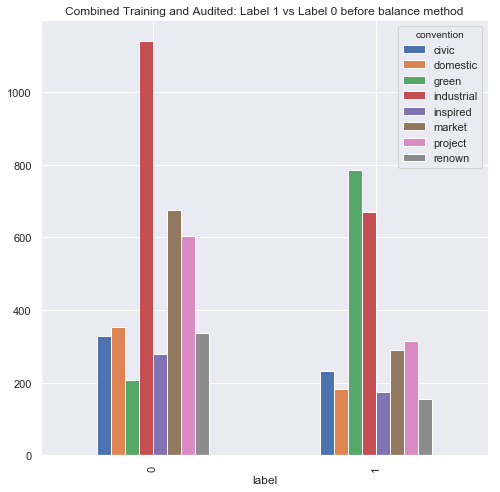

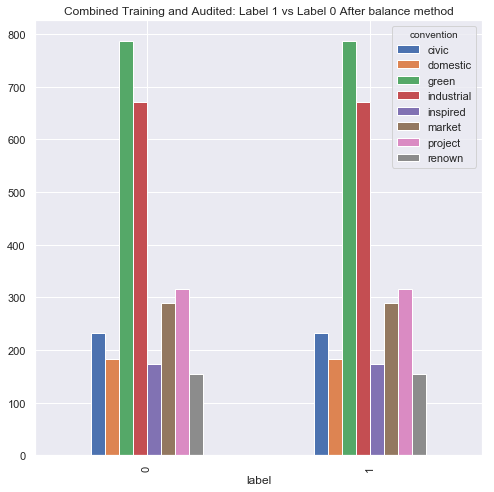

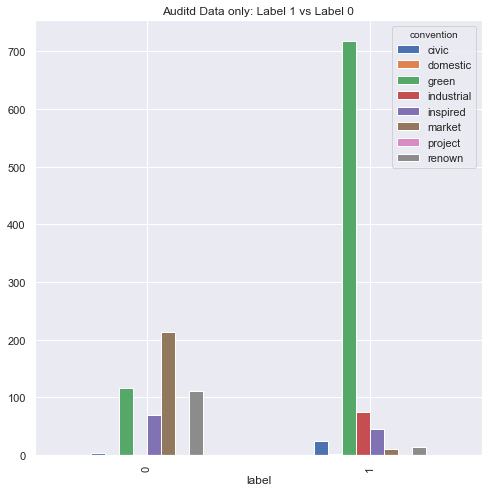

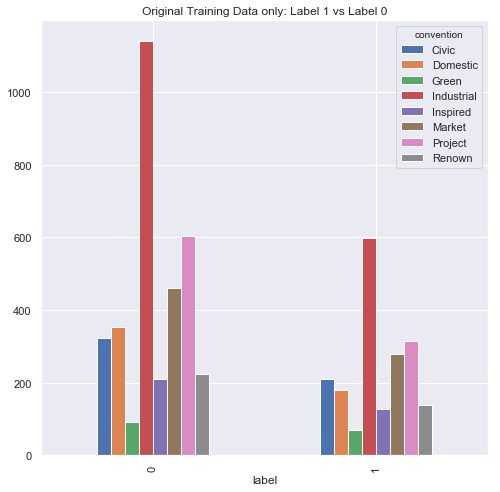

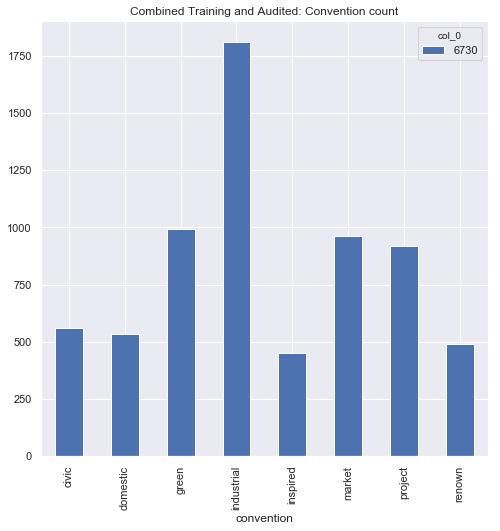

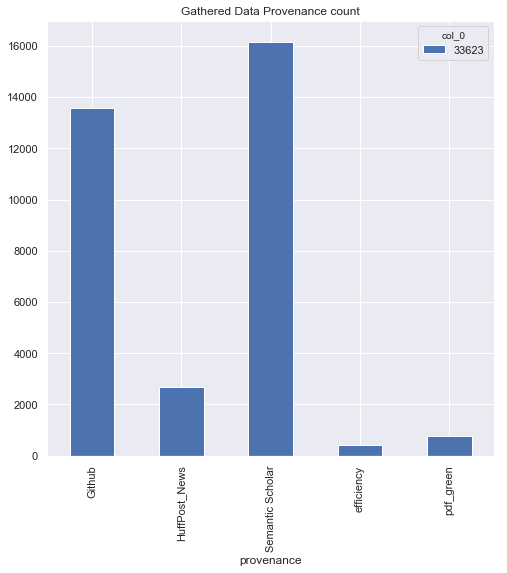

In [159]:
#Note there is a helper method "save_plot(....)"" which can be used to save these to GIT if requires

cross_tab_before.plot(kind='bar', figsize=(8, 8), title="Combined Training and Audited: Label 1 vs Label 0 before balance method")
cross_tab_after.plot(kind='bar', figsize=(8, 8), title ="Combined Training and Audited: Label 1 vs Label 0 After balance method")

cross_tab_audit_only = pd.crosstab(audited_data_df['label'],audited_data_df['convention'])
cross_tab_audit_only.plot(kind='bar', figsize=(8, 8), title ="Auditd Data only: Label 1 vs Label 0")

cross_tab_training_only = pd.crosstab(training_df['label'],training_df['convention'])
cross_tab_training_only.plot(kind='bar', figsize=(8, 8), title ="Original Training Data only: Label 1 vs Label 0")

cross_tab_new_training_data_df_conv = pd.crosstab(new_training_data_df['convention'], new_training_data_df['convention'].count())
cross_tab_new_training_data_df_conv.plot(kind='bar', figsize=(8, 8), title ="Combined Training and Audited: Convention count")

cross_tab_gathered = pd.crosstab(gathered_conventions_df['provenance'],gathered_conventions_df['provenance'].count())
cross_tab_gathered.plot(kind='bar', figsize=(8, 8), title ="Gathered Data Provenance count")

# Creating the embeddings and the stop words for the model training

In [124]:
#Read the glove word-embedding to obtain the embeddings_index 
embeddings_index = parsing_helpers.read_glove_embeddings(paths.GLOVE_DIR_LOCAL, model_helpers.EMBEDDING_DIM)
stopwords = parsing_helpers.get_stop_words(paths.STOP_WORDS_DIR_FILE_LOCAL)

In [126]:
column_to_tokenize = 'text'
gathered_and_training = pd.DataFrame(gathered_conventions_df[column_to_tokenize].append(training_df[column_to_tokenize]))##Adding training data sentences
extended_tokenizer = parsing_helpers.create_tokenizer(gathered_and_training, 
                                                        column_to_tokenize,
                                                        max_words=model_helpers.MAX_NB_WORDS)
display (type (gathered_and_training))

pandas.core.frame.DataFrame

In [137]:
new_training_data_df.head()

,convention,label,provenance,text
1,domestic,1,Manually_gathered,this package provides routines to construct gr...
2,domestic,1,Manually_gathered,** clearly see how your habits improved over
3,domestic,1,Manually_gathered,** create an individual reminder for each habi...
4,domestic,1,Manually_gathered,unit of work and continuity.
5,domestic,1,Manually_gathered,rpcs are often used for performance reasons wi...


In [ ]:
plot = df[['convention', 'new']].copy().rename(columns={"new": "Count"}).groupby('convention').count().plot(kind='bar', title="Audited per convention")  
   

In [ ]:
EXECUTE_EXAMPLE = True
if EXECUTE_EXAMPLE: #### JUST TO AVOID EXECUTING THIS CELL EVERY TIME

    NUM_SENTENCES_TO_SHOW=10
    
    ## Tokenizer was already trained!
    assert(extended_tokenizer is not None)


    ## Train DL models

    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models
                    (new_training_data_df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=False) 

    ## Train ML models
    _MLModels = model_helpers.train_ML_models(new_training_data_df) 

    ##Getting sentences from data
    test_sentences = new_training_data_df['text'].values

    ## Calculate probability scores for for text data combining DL predictions and ML predictions
    mixture_preds = model_helpers.calculate_matches_mixture(test_sentences, _MLModels, _DLModels, _DLTokenizers)

    ## Getting top sentences per convention
    for conv in _MLModels.keys():
        print("\n\n     {}    \n\n".format(conv))
        for s in test_sentences[mixture_preds[conv].argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
            print("{}\n".format(test_sentences[s]))
            
            
    ## Store DL models in a pickle file
    model_helpers.store_DL_models_in_picke("test.pickle", _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories, paths.PICKLED_MODELS_DIR)
    
    ## Read DL models from a pickle file
    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.read_pickle("test.pickle")


In [ ]:
CONVENTION = "Green"
df = training_df[training_df['convention'] == CONVENTION]

In [ ]:
## Checking performance setting validation data on the model training
## Validation data is created inside the models trainign function
conv_models = model_helpers.train_DL_models(df,
            data_class_column="convention", 
            data_label_column="label",
            df_val=None,
            tokenizer=extended_tokenizer,
            random_seed=0, 
            use_validation=True)

In [ ]:
## Checking performance setting validation data on the model training
## Validation data is created outside the models trainign function
## Training models
texts = df['text'].values
labels = df['label'].values

indices = np.arange(len(texts))
np.random.seed(0)
np.random.shuffle(indices)
texts = texts[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

x_train = texts[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = texts[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
df_train['text'] = x_train
df_train['label'] = y_train
df_train['convention'] = CONVENTION


df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
df_val['text'] = x_val
df_val['label'] = y_val
df_val['convention'] = CONVENTION

print("\n\n===========================")
print("WITH VALIDATION!")
print("===========================\n\n")
models2 = model_helpers.train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0, use_validation=True)


In [ ]:
######################
### Cross validation
######################

## 1. Split training, validation data outside the training function
## 2. Train a model with training data
## 3. Check performance (acc) of the model on training and validation
## 4. Repeat num_tests times
## Next cell plots results

## Number of tests = 10
num_tests = 10
num_epochs = 20

accs = []
val_accs = []
epochs = np.arange(0,num_epochs, 1)

texts = df['text'].values
labels = df['label'].values


for n in range(num_tests):
    print("\n\n=================================")
    print("               {}".format(n))
    print("=================================")
    indices = np.arange(len(texts))
    np.random.shuffle(indices)
    texts = texts[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

    x_train = texts[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = texts[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_train['text'] = x_train
    df_train['label'] = y_train
    df_train['convention'] = CONVENTION


    df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_val['text'] = x_val
    df_val['label'] = y_val
    df_val['convention'] = CONVENTION


    tmp_training = model_helpers.train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0,
                use_validation=True, 
                num_epochs = num_epochs)

    accs.append(tmp_training[4][CONVENTION].history['acc'])
    val_accs.append(tmp_training[4][CONVENTION].history['val_acc'])       


In [ ]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Checking performance on multiple random data partitions\n       ({} Convention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


for i in range(len(accs)):
    plt.plot(epochs,accs[i], label="Test {}".format(i))
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)
for i in range(len(val_accs)):
    plt.plot(epochs,val_accs[i], label="Test {}".format(i))
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()

In [ ]:
models2_tokenizer = models2[1][CONVENTION]
val_seq = models2_tokenizer.texts_to_sequences(x_val)
val_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds2 = models2[0][CONVENTION].predict(val_seq)
print("Real label for samples classified with value 0")
display(y_val[preds2[:,0]>preds2[:,1]])
print("Real label for samples classified with value 1")
display(y_val[preds2[:,0]<preds2[:,1]])

In [ ]:

print("\n\n===========================")    
print("WITHOUT VALIDATION!")
print("===========================\n\n")
models3 = model_helpers.train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=None,
                tokenizer = models2_tokenizer,
                random_seed=0, use_validation=False)


In [ ]:

val_seq = models2_tokenizer.texts_to_sequences(x_val)
val_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds2 = models2[0][CONVENTION].predict(val_seq)
print("Real label for samples classified with value 0")
display(y_val[preds2[:,0]>preds2[:,1]])
print("Real label for samples classified with value 1")
display(y_val[preds2[:,0]<preds2[:,1]])

In [ ]:

tok1 = parsing_helpers.create_tokenizer(training_df)
word_index = tok1.word_index
tok1_words = []
for word, i in word_index.items():
    tok1_words.append(word)

for idx, _df in enumerate(gathered_dfs[:-1]):
    tok2 = parsing_helpers.create_tokenizer(_df)
    word_index2 = tok2.word_index

    gathered_f = gathered_data_files[idx]

    tok2_words = []
    for word, i in word_index2.items():
        tok2_words.append(word)

    words_in_tok1 = [w for w in tok2_words if w in tok1_words]
    tok1_words_in_tok2 = [w for w in tok1_words if w in tok2_words]
    print("\n > {}".format(gathered_f))
    print("Gathered source words in training data: {}".format(len(words_in_tok1) / len(tok1_words)))
    print("Training data words in gathered source: {}".format(len(tok1_words_in_tok2) / len(tok2_words)))


In [ ]:

NUM_SENTENCES_TO_SHOW=10

df_test = pd.read_csv(os.path.join(paths.GATHERED_DATA_CONV_DIR_LOCAL, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(val_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    
    

In [ ]:
### Ading more green examples
green_audit_df = pd.read_csv("Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL_2019-10-08-20:23:58.598102.tsv", sep="\t")
green_audit_df = green_audit_df[['text', 'provenance', 'convention', 'new']]
green_audit_df = green_audit_df.rename(columns={"new": "label"})
green_audit_df = green_audit_df[green_audit_df['convention']=='green']
green_audit_df['convention'] = "Green"
green_audit_df.head(5)



In [ ]:
green_df = pd.concat([df, green_audit_df])

In [ ]:
######################
### Cross validation with new data
######################

## 1. Split training, validation data outside the training function
## 2. Train a model with training data
## 3. Check performance (acc) of the model on training and validation
## 4. Repeat num_tests times
## Next cell plots results

## Number of tests = 10
num_tests = 10
num_epochs = 20

accs2 = []
val_accs2 = []
epochs = np.arange(0,num_epochs, 1)

texts = green_df['text'].values
labels = green_df['label'].values
np.random.seed(0)

for n in range(num_tests):
    print("\n\n=================================")
    print("               {}".format(n))
    print("=================================")
    indices = np.arange(len(texts))

    np.random.shuffle(indices)
    texts = texts[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * len(texts))

    x_train = texts[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = texts[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    df_train = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_train['text'] = x_train
    df_train['label'] = y_train
    df_train['convention'] = CONVENTION


    df_val = pd.DataFrame(columns=['text', 'label', 'convention'])
    df_val['text'] = x_val
    df_val['label'] = y_val
    df_val['convention'] = CONVENTION


    tmp_training = model_helpers.train_DL_models(df_train,
                data_class_column="convention", 
                data_label_column="label",
                df_val=df_val,
                tokenizer=extended_tokenizer,
                random_seed=0,
                use_validation=True, 
                num_epochs = num_epochs)

    accs2.append(tmp_training[4][CONVENTION].history['acc'])
    val_accs2.append(tmp_training[4][CONVENTION].history['val_acc'])       


In [ ]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Checking performance on multiple random data partitions\n       ({} Convention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


for i in range(len(accs)):
    plt.plot(epochs,accs2[i], label="Test {}".format(i))
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)
for i in range(len(val_accs)):
    plt.plot(epochs,val_accs2[i], label="Test {}".format(i))
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()

In [ ]:
## Checking performance setting validation data on the model training
## Validation data is created inside the models trainign function
conv_models2 = model_helpers.train_DL_models(green_df,
            data_class_column="convention", 
            data_label_column="label",
            df_val=None,
            tokenizer=extended_tokenizer,
            random_seed=0, 
            use_validation=True)

In [ ]:
NUM_SENTENCES_TO_SHOW=20

df_test = pd.read_csv(os.path.join(GATHERED_DATA_FOLDER, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values
test_sentences = np.array([sent for sent in test_sentences if len(sent.split(" "))<40])

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models2[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> DL model results")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    

In [ ]:
_DLModels = conv_models2[0]
_DLTokenizers = conv_models2[1]

In [ ]:
_MLModels = model_helpers.train_ML_models(green_df)

In [ ]:
test_sentences = df_test['sentence'].values

mixture_preds = model_helpers.calculate_matches_mixture(test_sentences, _MLModels, _DLModels, _DLTokenizers)
print("-----------------------------------------------------")
print(" >> Mixture model results")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[mixture_preds[CONVENTION].argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))
    

    